In [21]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from shapely import wkt
import geopandas as gpd
from datetime import timedelta

script_path = os.path.abspath(os.path.join("..", "scripts"))
sys.path.append(script_path)

import plot_functions

### Load data

In [2]:
# # #### LOAD DATA DIRECTLY #####
# from google.cloud import bigquery
# client = bigquery.Client()
# table_id = "wsdemo-457314.ais.shadowtankers_anomalies"
# query = f"""SELECT * FROM {table_id}"""
# df = client.query(query).to_dataframe()
# df = df.drop_duplicates(subset=['mmsi', 'dt'])
# df.to_csv("../data/amomalous_pings.csv", index=False)

In [24]:
# Load from CSV
df = pd.read_csv("../data/amomalous_pings.csv")
df['dt'] = pd.to_datetime(df['dt'])
df = df.sort_values(by=['mmsi', 'dt'])

# load full shadowtanker set
full_df = pd.read_csv("../data/shadowtankers.csv")
full_df['dt'] = pd.to_datetime(full_df['dt'],format='mixed')

### Aggregate anomalous activity

In [29]:
time_window = '2h'

# Group rows of the same mmsi within the time window
df['time_group'] = df.groupby('mmsi')['dt'].transform(
    lambda x: x.diff().gt(pd.Timedelta(time_window)).cumsum()
)

# Aggregate the data
agg = df
agg['anomalous_pings']=1
agg = df.groupby(['mmsi', 'time_group']).agg(
    dt_start=('dt', 'min'),  # Start time of the group
    dt_end=('dt', 'max'),    # End time of the group
    h3_lv5=('h3_lv5','first'),
    anomalous_pings=('anomalous_pings', 'sum'),
    normalized_distance_sum=('normalized_distance', 'median'),
    normalized_distance_median=('normalized_distance', 'median') 
).sort_values('anomalous_pings', ascending=False).reset_index()

In [10]:
agg.to_csv("../products/4_anomalousactivity/anomalous_activity.csv", index=False)

### Generate anomalous_activity_heatmap

In [6]:
h3_agg = df.groupby(['h3_lv5']).agg(anomalous_pings=('anomalous_pings','sum'),
                                   normalized_distance_sum=('normalized_distance', 'sum')
                                  ).reset_index()

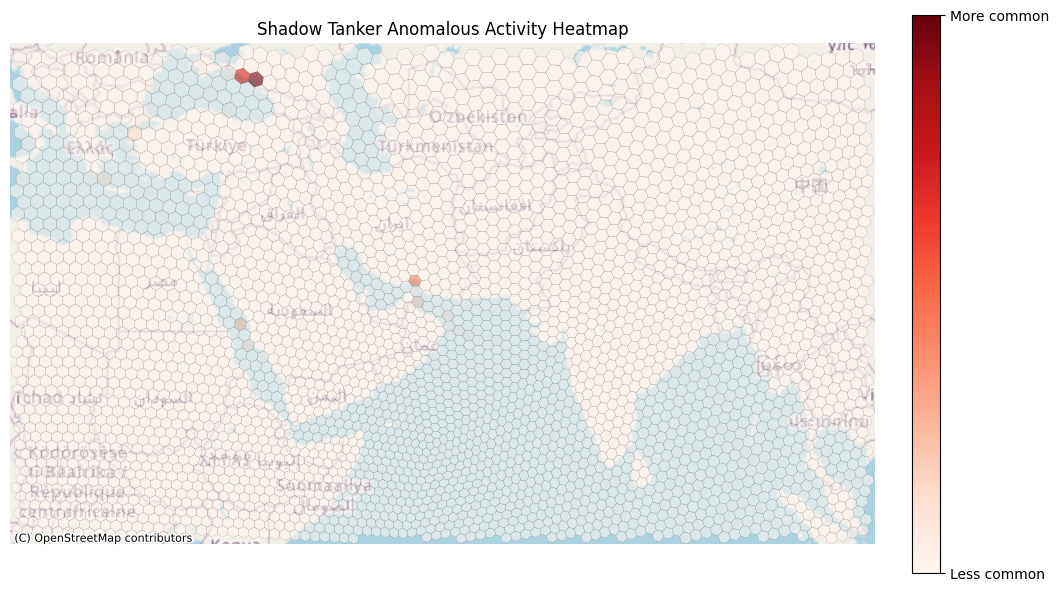

In [7]:
fig, ax = plot_functions.plot_h3_heatmap(
    df= h3_agg,
    h3_column="h3_lv5",
    heatmap_column="normalized_distance_sum",
    use_parent_level=3
)

plt.title("Shadow Tanker Anomalous Activity Heatmap")
plt.gcf().canvas.draw_idle()
plt.savefig("../products/4_anomalousactivity/shadowtanker_anomalous_activity_heatmap.jpg", dpi=100)
#bbox_inches="tight"

### Generate Vignette Plots

In [26]:
full_df['geometry'] = full_df['geometry'].apply(wkt.loads)
full_df = full_df[full_df['geometry'].apply(lambda geom: geom.is_valid if geom else False)]
gdf = gpd.GeoDataFrame(full_df, geometry='geometry', crs="EPSG:4326")

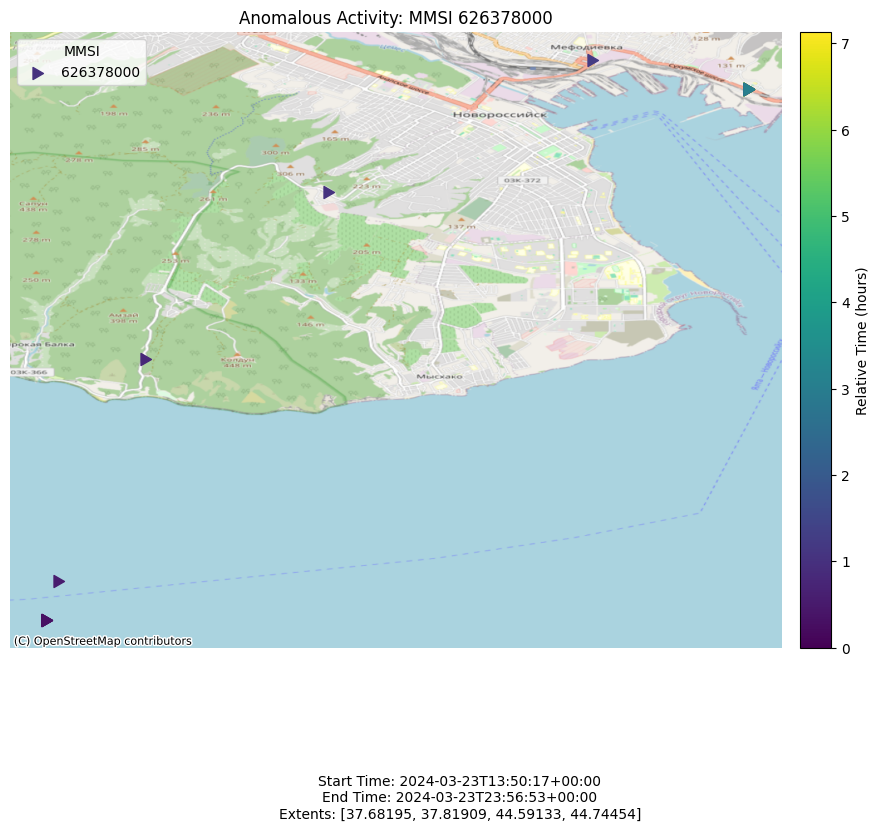

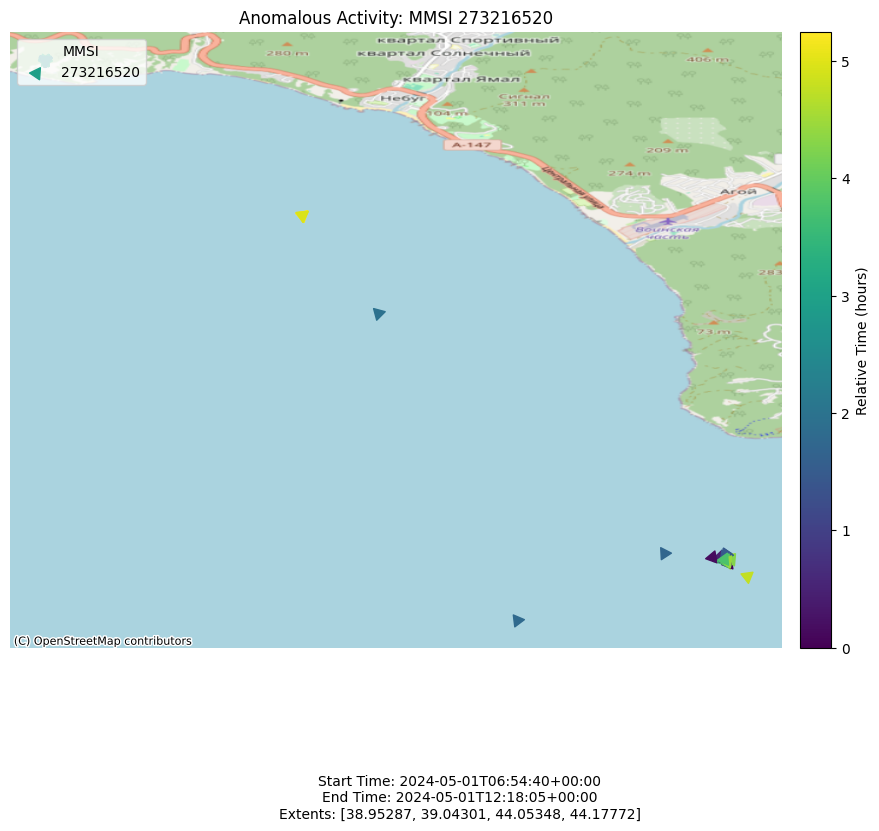

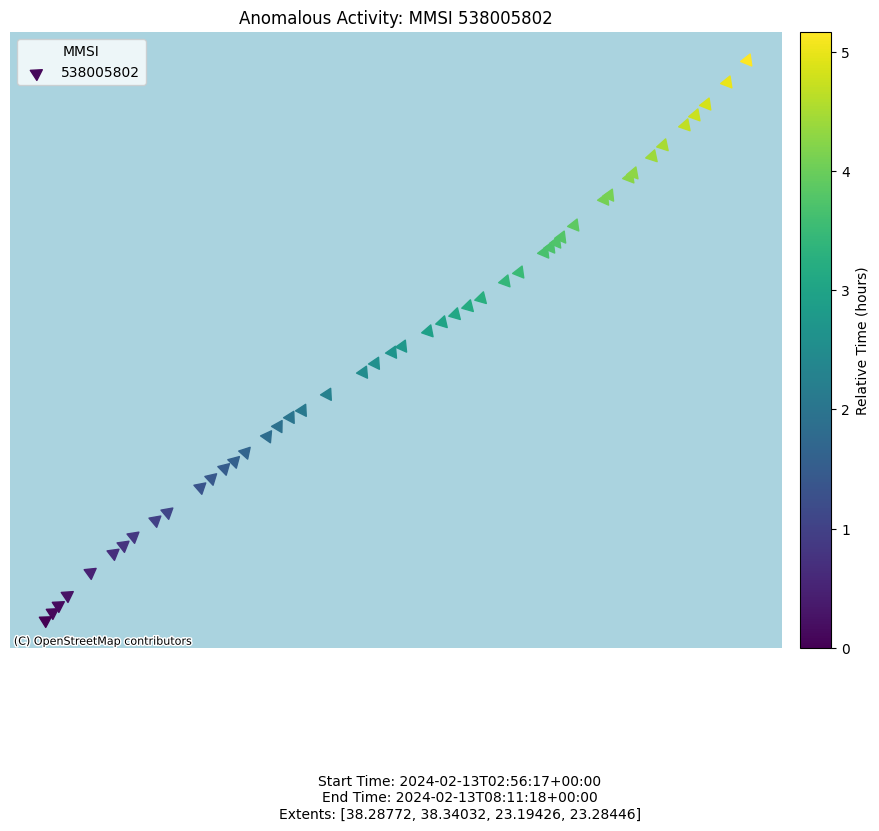

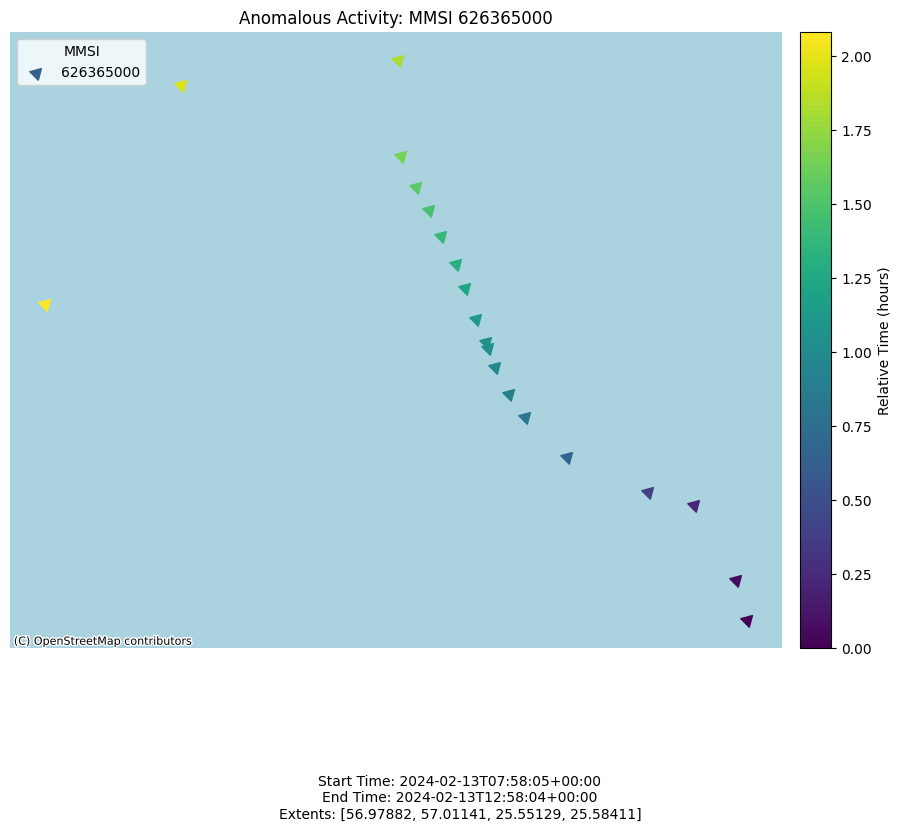

In [37]:
for i in range(0,4):
    vignette_row = agg.iloc[i]
    mmsi_list = [vignette_row["mmsi"]]
    start_time = vignette_row["dt_start"]-timedelta(hours=1)
    end_time = vignette_row["dt_end"]+timedelta(hours=1) 
    # Generate the vignette plot using the full GeoDataFrame (vessel_gdf)
    fig, ax = plot_functions.generate_vignette_plot(gdf, mmsi_list, start_time, end_time, buffer_hrs=1)
    plt.title(f"Anomalous Activity: MMSI {mmsi_list[0]}")
    plt.gcf().canvas.draw_idle()
    plt.savefig(f"../products/4_anomalousactivity/anomalous_activity_vignette_mmsi_{mmsi_list[0]}.jpg", dpi=100)